# Generate set of administrative regions to use in exposure grid
- The idea here is to get a globally comprehensive set of administrative boundaries at the `adm1` level or higher if the `adm1` level is not available
- Use `adm1` if available and `adm0` if not

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import geopandas as gpd
import pandas as pd
from shapely.errors import ShapelyDeprecationWarning

from sliiders import settings as sset
from sliiders import spatial

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


#### Read full `adm0` and `adm1` sets

In [3]:
adm0 = (
    gpd.read_file(sset.PATH_GADM, layer="level0")[["GID_0", "geometry"]]
    .set_crs(epsg=4326)
    .set_index("GID_0")
    .geometry
)
adm1 = (
    gpd.read_file(sset.PATH_GADM, layer="level1")[["GID_0", "GID_1", "geometry"]]
    .set_crs(epsg=4326)
    .set_index("GID_1")
)

#### Exclude non-territory ISOs
- `ATA`: Antarctica
- `XCA`: Caspian Sea

In [4]:
sset.EXCLUDED_ISOS

['ATA', 'XCA']

In [5]:
# Filter out excluded ISOs
adm0 = adm0[~adm0.index.isin(sset.EXCLUDED_ISOS)]
adm1 = adm1[~adm1["GID_0"].isin(sset.EXCLUDED_ISOS)]

#### Select only countries in `adm0` that do not appear in the `adm1` set, to be included as intermediate `adm1` regions

In [6]:
adm0_as_adm1 = adm0.drop(adm1.GID_0.unique())

#### Concatenate all `adm1` regions

In [7]:
full = pd.concat([adm0_as_adm1.to_frame(), adm1]).geometry.to_frame()
full["ISO"] = full.index.str.split(".").str[0]
full.index.name = "adm1"
assert full.index.is_unique
seg_centroids = gpd.read_file(sset.PATH_SEG_CENTROIDS).set_index("station_id").geometry
coastlines = gpd.read_file(sset.PATH_CIAM_COASTLINES).set_index("line_id").geometry
overlay_name = "seg_adm"

Generating global Voronoi shapes for regions...


  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Assigning countries to segment centroids...
Generating within-country Voronoi shapes for segment centroids...
ABW AGO AIA ALA ALB ARE ARG ASM ATF ATG AUS BEL BEN BES BGD BGR BHR BHS BIH BLM BLZ BMU BRA BRB BRN BVT CAN CCK CHL CHN CIV CMR COD COG COK COL COM CPV CRI CUB CUW CXR CYM CYP DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST FIN FJI FLK FRA FRO FSM GAB GBR GEO GGY GHA GIB GIN GLP GMB GNB GNQ GRC GRD GRL GTM GUF GUM GUY HKG HMD HND HRV HTI IDN IMN IND IOT IRL IRN IRQ ISL ISR ITA JAM JEY JOR JPN KEN KHM KIR KNA KOR KWT LBN LBR LBY LCA LKA LTU LVA MAF MAR MCO MDG MDV MEX MHL MLT MMR MNE MNP MOZ MRT MSR MTQ MUS MYS MYT NAM NCL NFK NGA NIC NIU NLD NOR NRU NZL OMN PAK PAN PCN PER PHL PLW PNG POL PRI PRK PRT PSE PYF QAT REU ROU RUS SAU SDN SEN SGP SGS SHN SJM SLB SLE SLV SOM SPM STP SUR SVN SWE SXM SYC SYR TCA TGO THA TKL TLS TON TTO TUN TUR TUV TWN TZA UKR UMI URY USA VCT VEN VGB VIR VNM VUT WLF WSM XAD XCL XNC XSP YEM ZAF Generating country-level coastlines...
Assigning segments to e

  0%|          | 0/207 [00:00<?, ?it/s]

ABW AGO AIA ALA ALB ARE ARG ASM ATF ATG AUS BEL BEN BES BGD BGR BHR BHS BIH BLM BLZ BMU BRA BRB BRN BVT CAN CCK CHL CHN CIV CMR COD COG COK COL COM CPV CRI CUB CUW CXR CYM CYP DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST FIN FJI FLK FRA FRO FSM GAB GBR GEO GGY GHA GIB GIN GLP GMB GNB GNQ GRC GRD GRL GTM GUF GUM GUY HKG HMD HND HRV HTI IDN IMN IND IOT IRL IRN IRQ ISL ISR ITA JAM JEY JOR JPN KEN KHM KIR KNA KOR KWT LBN LBR LBY LCA LKA LTU LVA MAF MAR MCO MDG MDV MEX MHL MLT MMR MNE MNP MOZ MRT MSR MTQ MUS MYS MYT NAM NCL NFK NGA NIC NIU NLD NOR NRU NZL OMN PAK PAN PCN PER PHL PLW PNG POL PRI PRK PRT PSE PYF QAT REU ROU RUS SAU SDN SEN SGP SGS SHN SJM SLB SLE SLV SOM SPM STP SUR SVN SWE SXM SYC SYR TCA TGO THA TKL TLS TON TTO TUN TUR TUV TWN TZA UKR UMI URY USA VCT VEN VGB VIR VNM VUT WLF WSM XAD XCL XNC XSP YEM ZAF 

  0%|          | 0/47 [00:00<?, ?it/s]

AFG AND ARM AUT AZE BDI BFA BLR BOL BTN BWA CAF CHE CZE ETH HUN KAZ KGZ LAO LIE LSO LUX MAC MDA MKD MLI MNG MWI NER NPL PRY RWA SMR SRB SSD SVK SWZ TCD TJK TKM UGA UZB VAT XKO XPI ZMB ZWE 

  0%|          | 0/8 [00:00<?, ?it/s]

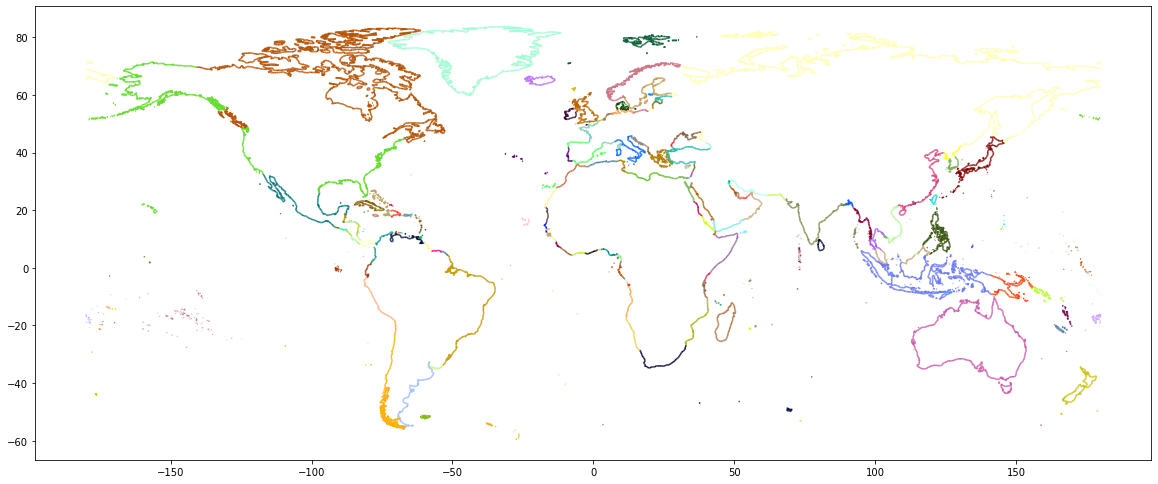

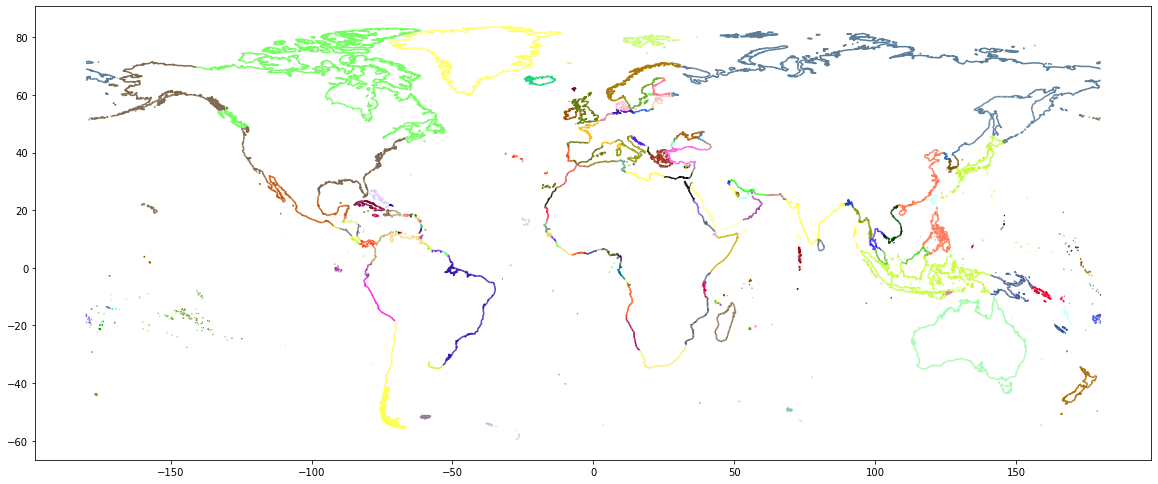

In [8]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
    all_overlays = spatial.create_overlay_voronois(
        full, seg_centroids, coastlines, overlay_name, plot=True
    )

In [ ]:
sset.PATH_CIAM_ADM1_VORONOI_INTERSECTIONS.parent.mkdir(exist_ok=False)

all_overlays.to_parquet(sset.PATH_CIAM_ADM1_VORONOI_INTERSECTIONS, index=False)
all_overlays.to_file(sset.PATH_CIAM_ADM1_VORONOI_INTERSECTIONS_SHP)